In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.datasets import make_circles
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB
import pickle
from sklearn.externals import joblib


In [16]:
import pandas as pd
import os 
print(os.getcwd())
data = pd.read_csv('../stats.txt', delim_whitespace=True)
data = data.sample(frac=1).reset_index(drop=True)
modelfile = 'final.sav'


array = data.values

print(data.head())
print(data.shape)
data.columns=['col1','col2','col3','col4','col5','col6','col7','col8','col9','col10','col11','col12','col13','col14','col15','col16','col17']
#data['x'],data['y'],data['z'],data['nx'],data['ny']=data['col2'].str.split('-')
z = data['col2'].str.split('-')
print(z.head())
data['col13']=data['col13'].eq("enable").mul(1)
data['col14']=data['col14'].eq("enable").mul(1)
data['col15']=data['col15'].eq("enable").mul(1)
data['col16']=data['col16'].eq("enable").mul(1)

/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active
   S3D-IO    50-50-100-2-2-4-1    0.00  0.00.1  0.00.2     2.14   0.15  71.19  \
0  S3D-IO   50-100-100-2-2-4-1  325.28    0.06    0.19   359.09   0.30   0.85   
1  S3D-IO  200-400-400-2-4-4-1    0.00    0.00    0.00  1086.34  19.07  17.98   
2  S3D-IO  100-400-400-2-4-4-1  977.33    1.91    2.00   783.88   5.72   7.47   
3  S3D-IO   50-100-100-2-2-4-1  448.82    0.06    0.14   394.71   0.30   0.77   
4  S3D-IO     50-50-50-2-2-2-1   73.56    0.02    0.21   354.61   0.04   0.13   

   0.06  0.01   1048576   1  disable disable.1 disable.2 disable.3       1024  
0  0.05  0.02    131072   3  disable   disable    enable   disable  255852544  
1  0.09  0.11    131072  13  disable   disable    enable   disable  557842432  
2  0.05  0.19  14680064  10  disable   disable    enable   disable  519045120  
3  0.06  0.03     65536   2  disable   disable   disable   disable  838860800  
4  0.04  0.01    327680   2  disable

In [20]:


X_temp = pd.DataFrame() #creates a new dataframe that's empty
X = pd.DataFrame(z.tolist())
X = X.drop(6, 1)


X_temp['cb1']=data['col11']
X_temp['cb2']=data['col12']
#X['cb3']=data['col13']
#X['cb4']=data['col14']
#X['cb5']=data['col15']
#X['cb6']=data['col16']
X_temp['cb7']=data['col17']

#temp = X_temp.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(temp)
#X_temp = pd.DataFrame(x_scaled)
X =pd.concat([X, X_temp], axis=1)
X['ratio1'] = X.iloc[:,0].astype(int)/(X.iloc[:,3].astype(int)*100)
X['ratio2'] = X.iloc[:,1].astype(int)/(X.iloc[:,4].astype(int)*100)
X['ratio3'] = X.iloc[:,2].astype(int)/(X.iloc[:,5].astype(int)*100)
X_scaled = min_max_scaler.fit_transform(X.values)
X = pd.DataFrame(X_scaled)
print(type(X))
print(X.head())
i=0

for _ in X.columns:
    if(i == 0):
        continue
    X.iloc[:,i].astype(int)
    print(i)
    i=i+1 

#pd.options.display.max_rows=  1500
#print(X.iloc[:,0])



<class 'pandas.core.frame.DataFrame'>
         0         1         2    3    4         5         6         7   \
0  0.000000  0.142857  0.066667  0.0  0.0  0.333333  0.000109  0.006186   
1  0.428571  1.000000  0.466667  0.0  1.0  0.333333  0.000109  0.026804   
2  0.142857  1.000000  0.466667  0.0  1.0  0.333333  0.012260  0.020619   
3  0.000000  0.142857  0.066667  0.0  0.0  0.333333  0.000055  0.004124   
4  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000274  0.004124   

         8         9         10        11  
0  0.238469  0.000000  0.142857  0.000000  
1  0.521099  0.428571  0.428571  0.428571  
2  0.484789  0.142857  0.428571  0.428571  
3  0.784102  0.000000  0.142857  0.000000  
4  0.450442  0.000000  0.000000  0.000000  


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [18]:
Y = data['col6']
Y=Y.values
Y = Y*100
Y = Y.astype(int)


msk = np.random.rand(len(X)) < 0.8
train_X = X[msk]
test_X = X[~msk]
train_Y = Y[msk]
test_Y = Y[~msk]
print(type(train_X))

y = train_Y
X = train_X
#X = train_X.astype(int)


print(X[0:5])
print(type(X))

print(y.shape, X.shape)
print(y[0:5])



<class 'pandas.core.frame.DataFrame'>
          0         1         2    3    4         5         0         1  \
0  0.000000  0.142857  0.066667  0.0  0.0  0.333333  0.000109  0.006186   
1  0.428571  1.000000  0.466667  0.0  1.0  0.333333  0.000109  0.026804   
2  0.142857  1.000000  0.466667  0.0  1.0  0.333333  0.012260  0.020619   
3  0.000000  0.142857  0.066667  0.0  0.0  0.333333  0.000055  0.004124   
5  0.428571  1.000000  0.466667  0.0  0.0  0.333333  0.000164  0.032990   

          2  ratio1    ratio2  ratio3  
0  0.238469     NaN       NaN     NaN  
1  0.521099     NaN  0.010000     NaN  
2  0.484789     NaN  0.010000     NaN  
3  0.784102     NaN       NaN     NaN  
5  0.033366     NaN       inf     NaN  
<class 'pandas.core.frame.DataFrame'>
(907,) (907, 12)
[ 35909 108633  78388  39471  60076]


In [5]:
hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
X_transformed = hasher.fit_transform(X)
X_transformed

<886x75 sparse matrix of type '<class 'numpy.float64'>'
	with 8860 stored elements in Compressed Sparse Row format>

In [6]:
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X_transformed)


In [7]:
nb = BernoulliNB()
nb.fit(X_transformed, y)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [8]:
trees = ExtraTreesClassifier(max_depth=1000, n_estimators=300, random_state=0)
trees.fit(X, y)



ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=1000, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [9]:
print(test_X.head(1))
print(test_X.shape)
trees.predict(test_X.head(1))

     0    1    2  3  4  5         0         1         2  ratio1  ratio2  \
0  100  200  400  2  4  4  0.011111  0.004124  0.053974     0.5     0.5   

   ratio3  
0     1.0  
(255, 12)


array([66594])

In [10]:
predicted = trees.predict(test_X)
#print(test_Y)
from sklearn.metrics import r2_score
r2_score(test_Y,predicted)

0.7928303033386507

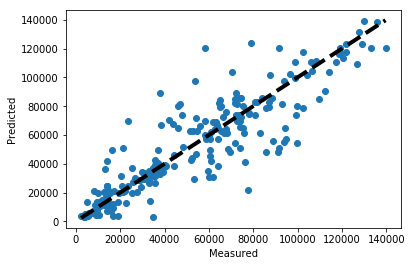

In [11]:
fig, ax = plt.subplots()
ax.scatter(test_Y, predicted)
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [12]:
# save the model to disk

modelfile = 'final.sav'
pickle.dump(trees, open(modelfile, 'wb'))
scaler_filename = "scaler.save"
joblib.dump(min_max_scaler, scaler_filename) 


['scaler.save']

In [13]:
import json
with open('/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/confex.json') as f:
    data = json.load(f)

romio_ds_read = data["mpi"]["romio_ds_read"]
romio_ds_write = data["mpi"]["romio_ds_write"]
romio_cb_read = data["mpi"]["romio_cb_read"]
romio_cb_write = data["mpi"]["romio_cb_write"]
cb_buffer_size = data["mpi"]["cb_buffer_size"]
stripe_size = data["lfs"]["setstripe"]["size"]
stripe_count = data["lfs"]["setstripe"]["count"]

col_names =  ['cb1', 'cb2', 'cb5','cb6','cb7']
cb_df  = pd.DataFrame(columns = col_names)
cb_df.loc[len(cb_df)] = [romio_ds_read,romio_ds_write,stripe_size, stripe_count, cb_buffer_size]


scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 
norm_df = scaler.transform( cb_df )
temp = pd.DataFrame(norm_df)




col_names =  ['0','1', '2','3','4','5','6','7','8','9','10']
my_df = pd.DataFrame(columns=col_names)
my_df.loc[len(my_df)] = [100,100,100,2,2,4]
x = pd.concat([my_df,temp], axis=1)


print(trees.predict(x))

ValueError: could not convert string to float: 'enable'

In [ ]:
print(predicted)

In [ ]:
x


In [ ]:
test_X.head(1)

In [ ]:
trees.predict(test_X.head(1))